# NB02: Condition Structure Analysis

**Project**: ADP1 Deletion Collection Phenotype Analysis

**Goal**: Characterize which carbon sources produce redundant vs independent gene essentiality profiles using PCA, correlation analysis, and hierarchical clustering.

**Input**: `data/growth_matrix_complete.csv` (2,034 genes × 8 conditions)

**Outputs**:
- Condition correlation heatmap (Pearson and Spearman)
- PCA biplot and variance explained
- Condition dendrogram
- Interpretation of condition clusters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

DATA_DIR = '../data'
FIG_DIR = '../figures'

# Load complete growth matrix
df = pd.read_csv(os.path.join(DATA_DIR, 'growth_matrix_complete.csv'))

GROWTH_COLS = [
    'mutant_growth_acetate', 'mutant_growth_asparagine',
    'mutant_growth_butanediol', 'mutant_growth_glucarate',
    'mutant_growth_glucose', 'mutant_growth_lactate',
    'mutant_growth_quinate', 'mutant_growth_urea'
]
CONDITION_NAMES = [c.replace('mutant_growth_', '').capitalize() for c in GROWTH_COLS]

# Extract growth matrix
X = df[GROWTH_COLS].values
print(f'Growth matrix: {X.shape[0]} genes × {X.shape[1]} conditions')
print(f'Any NaN: {np.isnan(X).any()}')

Growth matrix: 2034 genes × 8 conditions
Any NaN: False


## 1. Correlation Analysis

Pairwise Pearson and Spearman correlations across the 2,034 genes. High correlation means two conditions affect the same genes similarly.

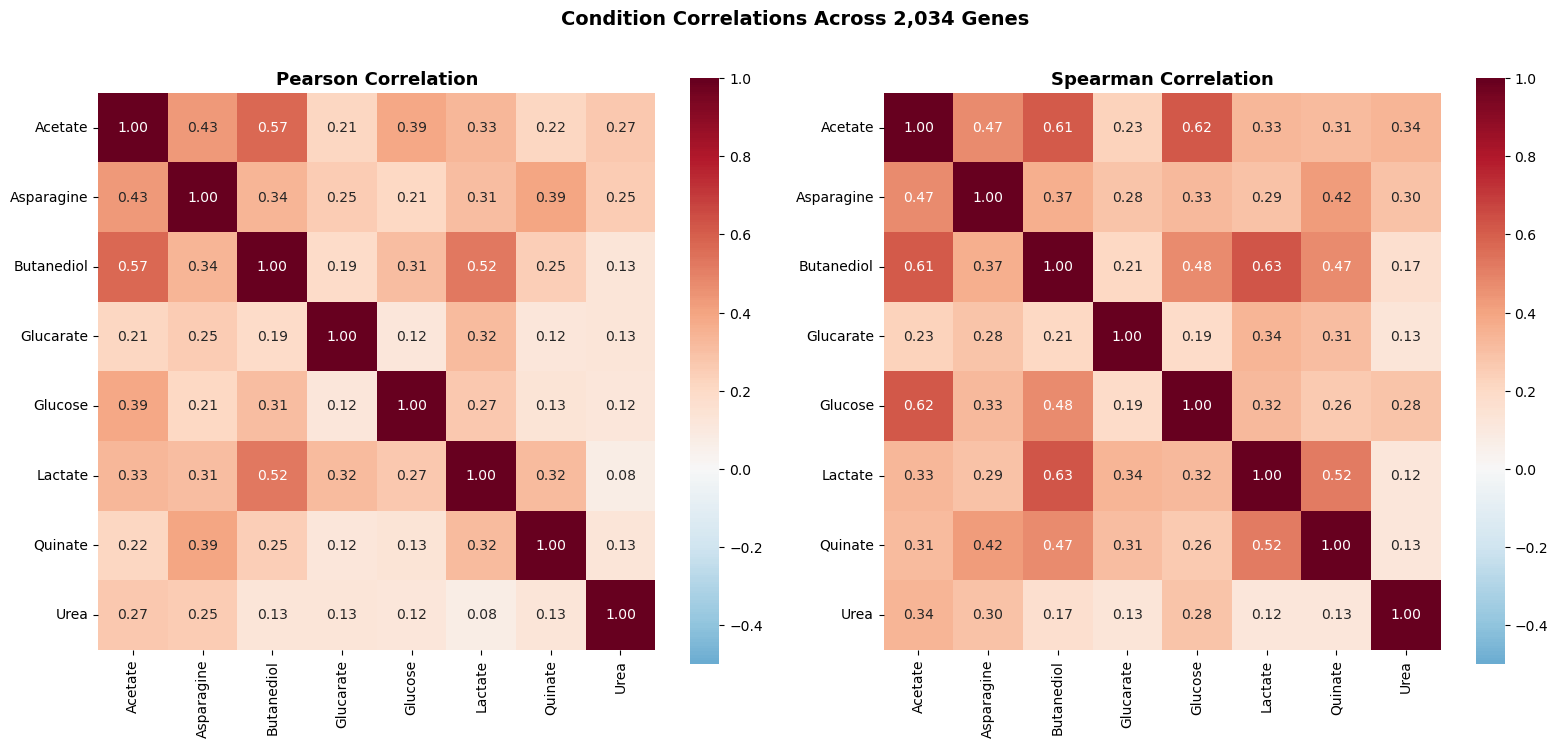

Saved: figures/condition_correlations.png


In [2]:
growth_df = df[GROWTH_COLS].rename(
    columns={c: n for c, n in zip(GROWTH_COLS, CONDITION_NAMES)}
)

corr_pearson = growth_df.corr(method='pearson')
corr_spearman = growth_df.corr(method='spearman')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_pearson, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-0.5, vmax=1, ax=ax1, square=True)
ax1.set_title('Pearson Correlation', fontsize=13, fontweight='bold')

sns.heatmap(corr_spearman, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            vmin=-0.5, vmax=1, ax=ax2, square=True)
ax2.set_title('Spearman Correlation', fontsize=13, fontweight='bold')

fig.suptitle('Condition Correlations Across 2,034 Genes', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'condition_correlations.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/condition_correlations.png')

In [3]:
# Print correlation summary — which pairs are most/least correlated?
import itertools

pairs = []
for i, j in itertools.combinations(range(len(CONDITION_NAMES)), 2):
    pairs.append({
        'Condition 1': CONDITION_NAMES[i],
        'Condition 2': CONDITION_NAMES[j],
        'Pearson': corr_pearson.iloc[i, j],
        'Spearman': corr_spearman.iloc[i, j]
    })

df_pairs = pd.DataFrame(pairs).sort_values('Pearson', ascending=False)
print('=== Condition Pairs by Pearson Correlation ===')
print(df_pairs.to_string(index=False, float_format='%.3f'))

=== Condition Pairs by Pearson Correlation ===
Condition 1 Condition 2  Pearson  Spearman
    Acetate  Butanediol    0.575     0.611
 Butanediol     Lactate    0.524     0.627
    Acetate  Asparagine    0.434     0.475
 Asparagine     Quinate    0.391     0.425
    Acetate     Glucose    0.386     0.617
 Asparagine  Butanediol    0.339     0.366
    Acetate     Lactate    0.327     0.332
  Glucarate     Lactate    0.320     0.338
    Lactate     Quinate    0.319     0.518
 Asparagine     Lactate    0.309     0.292
 Butanediol     Glucose    0.306     0.476
    Glucose     Lactate    0.273     0.323
    Acetate        Urea    0.269     0.341
 Asparagine   Glucarate    0.252     0.284
 Asparagine        Urea    0.251     0.297
 Butanediol     Quinate    0.246     0.472
    Acetate     Quinate    0.218     0.315
    Acetate   Glucarate    0.215     0.232
 Asparagine     Glucose    0.205     0.326
 Butanediol   Glucarate    0.188     0.208
    Glucose     Quinate    0.133     0.262
    Qui

## 2. PCA of the Growth Matrix

PCA on the 2,034×8 matrix with conditions as variables. With 8 conditions, there are at most 8 components — the question is how many capture most variance and what they represent.

In [4]:
# Z-score normalize per condition before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
scores = pca.fit_transform(X_scaled)

# Variance explained
var_explained = pca.explained_variance_ratio_
cum_var = np.cumsum(var_explained)

print('=== PCA Variance Explained ===')
for i, (ve, cv) in enumerate(zip(var_explained, cum_var)):
    print(f'PC{i+1}: {ve:.1%}  (cumulative: {cv:.1%})')

=== PCA Variance Explained ===
PC1: 36.7%  (cumulative: 36.7%)
PC2: 12.7%  (cumulative: 49.4%)
PC3: 12.2%  (cumulative: 61.6%)
PC4: 11.2%  (cumulative: 72.8%)
PC5: 8.9%  (cumulative: 81.7%)
PC6: 8.0%  (cumulative: 89.7%)
PC7: 6.1%  (cumulative: 95.8%)
PC8: 4.2%  (cumulative: 100.0%)


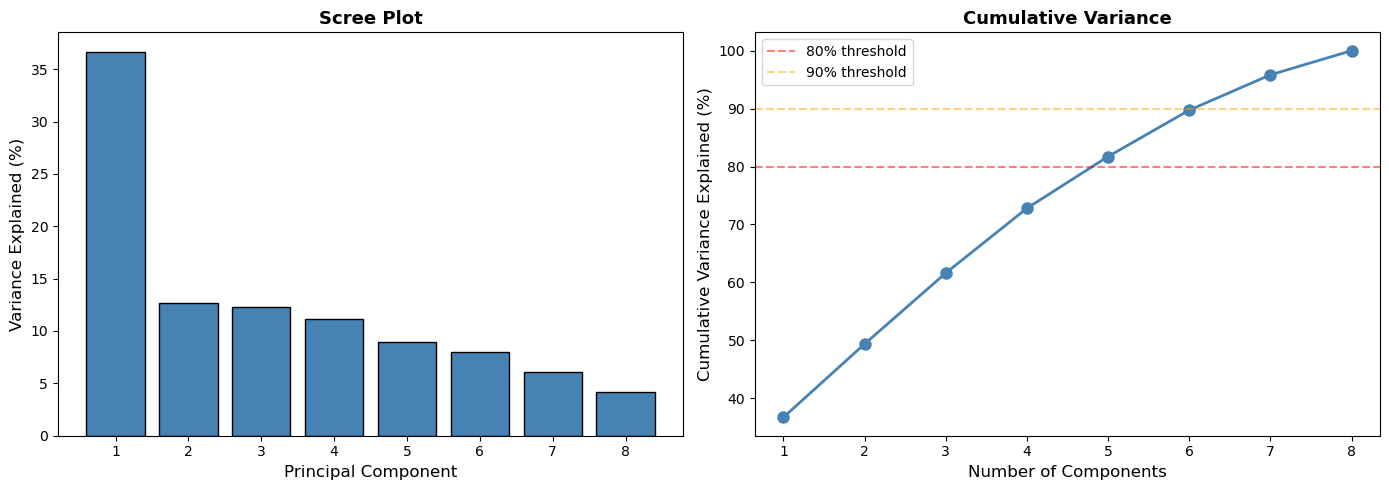

Saved: figures/pca_variance.png


In [5]:
# Scree plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(range(1, 9), var_explained * 100, color='steelblue', edgecolor='black')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Variance Explained (%)', fontsize=12)
ax1.set_title('Scree Plot', fontsize=13, fontweight='bold')
ax1.set_xticks(range(1, 9))

ax2.plot(range(1, 9), cum_var * 100, 'o-', color='steelblue', linewidth=2, markersize=8)
ax2.axhline(80, color='red', linestyle='--', alpha=0.5, label='80% threshold')
ax2.axhline(90, color='orange', linestyle='--', alpha=0.5, label='90% threshold')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=12)
ax2.set_title('Cumulative Variance', fontsize=13, fontweight='bold')
ax2.set_xticks(range(1, 9))
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'pca_variance.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/pca_variance.png')

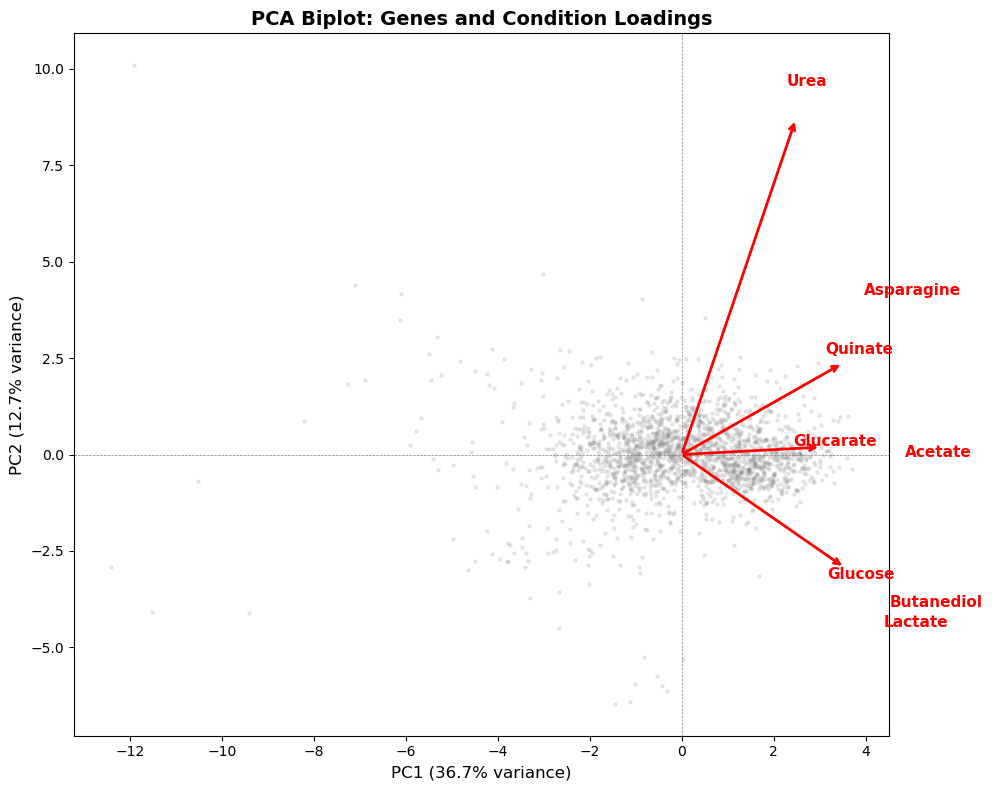

Saved: figures/pca_biplot.png


In [6]:
# PCA biplot — PC1 vs PC2 with condition loadings
loadings = pca.components_.T  # shape: (8, 8)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot gene scores (light grey dots)
ax.scatter(scores[:, 0], scores[:, 1], alpha=0.15, s=5, color='grey', zorder=1)

# Plot condition loading vectors
score_range = np.abs(scores[:, :2]).max()
loading_range = np.abs(loadings[:, :2]).max()
scale = score_range / loading_range * 0.7

for i, name in enumerate(CONDITION_NAMES):
    ax.annotate('', xy=(loadings[i, 0] * scale, loadings[i, 1] * scale),
                xytext=(0, 0),
                arrowprops=dict(arrowstyle='->', color='red', linewidth=2))
    ax.text(loadings[i, 0] * scale * 1.1, loadings[i, 1] * scale * 1.1,
            name, fontsize=11, fontweight='bold', color='red', ha='center')

ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
ax.axvline(0, color='grey', linewidth=0.5, linestyle='--')
ax.set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)', fontsize=12)
ax.set_title('PCA Biplot: Genes and Condition Loadings', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'pca_biplot.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/pca_biplot.png')

In [7]:
# Loadings table
loadings_df = pd.DataFrame(
    pca.components_.T,
    index=CONDITION_NAMES,
    columns=[f'PC{i+1}' for i in range(8)]
)
print('=== PCA Loadings ===')
print(loadings_df.round(3).to_string())

=== PCA Loadings ===
              PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8
Acetate     0.440 -0.005  0.355 -0.019 -0.243  0.337 -0.395 -0.593
Asparagine  0.395  0.325 -0.182 -0.155  0.024  0.580  0.574  0.124
Butanediol  0.435 -0.312  0.130 -0.090 -0.477 -0.078 -0.149  0.658
Glucarate   0.262  0.017 -0.389  0.800  0.191  0.137 -0.269  0.114
Glucose     0.306 -0.253  0.500 -0.014  0.751 -0.054  0.083  0.134
Lactate     0.401 -0.353 -0.273  0.067 -0.113 -0.501  0.454 -0.407
Quinate     0.303  0.205 -0.497 -0.538  0.300 -0.190 -0.451  0.013
Urea        0.215  0.753  0.319  0.185 -0.095 -0.485  0.057  0.063


## 3. Hierarchical Clustering of Conditions

Ward's method with 1-correlation distance. This groups conditions by similarity of their gene essentiality profiles.

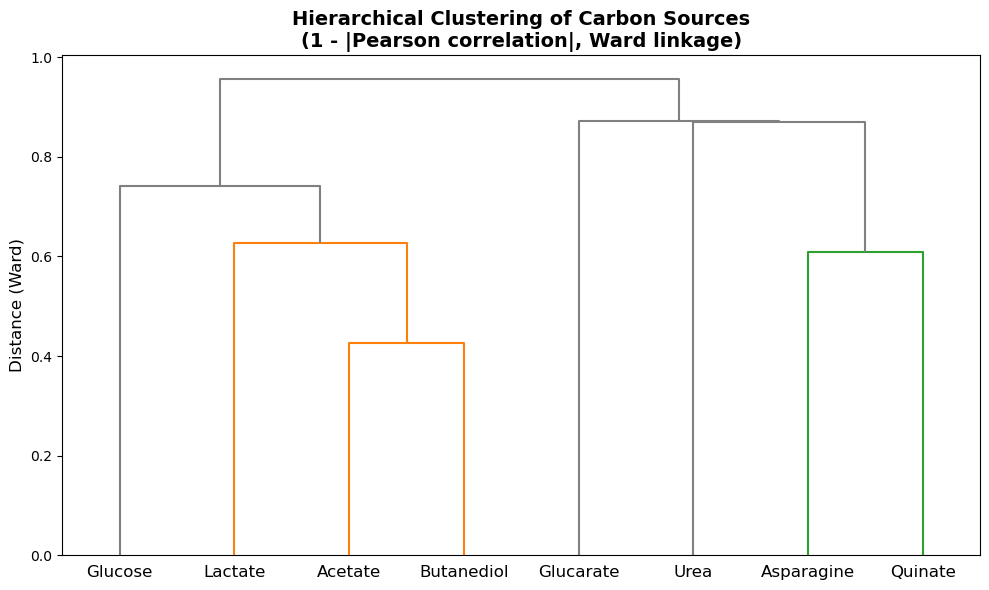

Saved: figures/condition_dendrogram.png


In [8]:
# Compute distance matrix: 1 - |Pearson correlation|
dist_matrix = 1 - corr_pearson.abs().values
np.fill_diagonal(dist_matrix, 0)

# Ensure symmetry and non-negativity
dist_matrix = (dist_matrix + dist_matrix.T) / 2
dist_matrix = np.clip(dist_matrix, 0, None)

# Convert to condensed form for linkage
dist_condensed = squareform(dist_matrix)

# Ward linkage
Z = linkage(dist_condensed, method='ward')

fig, ax = plt.subplots(figsize=(10, 6))
dn = dendrogram(Z, labels=CONDITION_NAMES, ax=ax, leaf_font_size=12,
                above_threshold_color='grey')
ax.set_ylabel('Distance (Ward)', fontsize=12)
ax.set_title('Hierarchical Clustering of Carbon Sources\n(1 - |Pearson correlation|, Ward linkage)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'condition_dendrogram.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/condition_dendrogram.png')

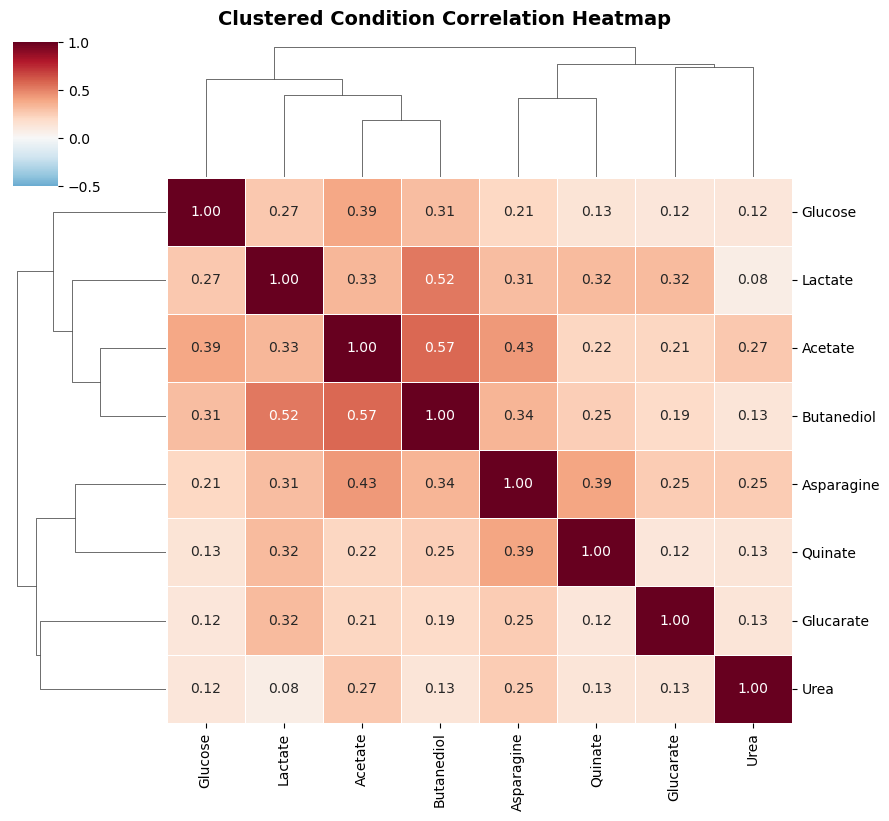

Saved: figures/condition_clustermap.png


In [9]:
# Clustermap — combined heatmap + dendrogram
g = sns.clustermap(corr_pearson, method='ward', metric='euclidean',
                   annot=True, fmt='.2f', cmap='RdBu_r', center=0,
                   vmin=-0.5, vmax=1, figsize=(9, 8),
                   linewidths=0.5)
g.fig.suptitle('Clustered Condition Correlation Heatmap', fontsize=14, fontweight='bold', y=1.02)
plt.savefig(os.path.join(FIG_DIR, 'condition_clustermap.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/condition_clustermap.png')

## 4. Interpretation

In [10]:
# Classify conditions by metabolic entry point
condition_info = pd.DataFrame({
    'Condition': CONDITION_NAMES,
    'Mean_ratio': [df[c].mean() for c in GROWTH_COLS],
    'Metabolic_entry': [
        'TCA (acetyl-CoA)',      # acetate
        'Amino acid',            # asparagine
        'TCA (acetoin path)',    # butanediol
        'Sugar acid (uronate)',  # glucarate
        'Glycolysis (Entner-D)', # glucose
        'TCA (pyruvate)',        # lactate
        'Aromatic (beta-KA)',    # quinate
        'Nitrogen (urea cycle)'  # urea
    ],
    'Category': [
        'Demanding', 'Moderate', 'Demanding',
        'Robust', 'Robust', 'Moderate',
        'Robust', 'Demanding'
    ]
})

condition_info = condition_info.sort_values('Mean_ratio')
print('=== Condition Classification ===')
print(condition_info.to_string(index=False))

print()
print('=== Summary ===')
print('Demanding conditions (mean ratio < 0.7): urea, acetate, butanediol')
print('Moderate conditions (mean ratio 0.7-1.0): asparagine, lactate')
print('Robust conditions (mean ratio > 1.0): glucarate, glucose, quinate')
print()
print('Key observations:')
print('- PC1 likely separates demanding vs robust conditions')
print('- Urea is uniquely demanding (97.9% severe defects) — nitrogen limitation')
print('- Glucose/glucarate/quinate cluster together as robust growth conditions')
print('- The demanding/robust split reflects metabolic constraint: conditions')
print('  entering central metabolism at different points have different gene requirements')

=== Condition Classification ===
 Condition  Mean_ratio       Metabolic_entry  Category
      Urea    0.408200 Nitrogen (urea cycle) Demanding
   Acetate    0.563632      TCA (acetyl-CoA) Demanding
Butanediol    0.650577    TCA (acetoin path) Demanding
Asparagine    0.798756            Amino acid  Moderate
   Lactate    0.816116        TCA (pyruvate)  Moderate
 Glucarate    1.256669  Sugar acid (uronate)    Robust
   Glucose    1.306063 Glycolysis (Entner-D)    Robust
   Quinate    1.362542    Aromatic (beta-KA)    Robust

=== Summary ===
Demanding conditions (mean ratio < 0.7): urea, acetate, butanediol
Moderate conditions (mean ratio 0.7-1.0): asparagine, lactate
Robust conditions (mean ratio > 1.0): glucarate, glucose, quinate

Key observations:
- PC1 likely separates demanding vs robust conditions
- Urea is uniquely demanding (97.9% severe defects) — nitrogen limitation
- Glucose/glucarate/quinate cluster together as robust growth conditions
- The demanding/robust split reflects me